In [1]:
# functions for post-processing

In [2]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs      # map projections
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable
import re
from bpch2nc import bpch_2_netcdf
from multiprocessing import Pool

In [4]:
def month_string(month): # string for a month, input 3 output '03'
    if(month >= 10):
        mm_str = str(month)
    else:
        mm_str = '0' + str(month)
    return mm_str
#month_string(3)

In [5]:
# a correct leap year function! might not needed at all
def leap_year(year):
    ans = False
    if year%4 == 0 and year%100 !=0:
        ans = True
    if year%400 == 0:
        ans = True
    return ans
#leap_year(2016)

In [8]:
def days_str_in_a_month(year, month): # returns days in a month, in numpy datetime64[D] format
    month_str = month_string(month)
    if month <= 11:
        first_day = str(year) + '-' + month_str + '-01'
        month_str_p1 = month_string(month+1)
        last_day_p1 = str(year) + '-' + month_str_p1 + '-01'
    else:
        first_day = str(year) + '-' + month_str + '-01'
        month_str_p1 = month_string(1)
        last_day_p1 = str(year+1) + '-' + month_str_p1 + '-01'
        
    return np.arange(first_day, last_day_p1, dtype='datetime64[D]')

#days_str_in_a_month(2018,2)

array(['2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04',
       '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
       '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12',
       '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16',
       '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20',
       '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-24',
       '2018-02-25', '2018-02-26', '2018-02-27', '2018-02-28'],
      dtype='datetime64[D]')

In [11]:
def short_name_of_month(month): # returns short name of month
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    name_month = month_names[month-1]
    return name_month

short_name_of_month(3)

'Mar'

In [12]:
def long_name_of_month(month): # returns short name of month
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    name_month = month_names[month-1]
    return name_month

long_name_of_month(3)

'March'

In [10]:
# convert bpch files to netcdf format, for a given year and month
def bpch_to_nc_mass(data_dir, year, month):
    
    name_bpch1 = 'ts_satellite.'
    
    tinfo_file = data_dir + 'tracerinfo.dat'
    dinfo_file = data_dir + 'diaginfo.dat'
    
    days = days_str_in_a_month(year, month)
    
    for iday in np.arange(len(days)):
        day_string = days[iday] # format not right for the following function
        #print('converting bpch to netcdf on day: ', day_string)
        new_day_string = re.sub("[^0-9]", "", str(day_string)) # strip off '-'s

        bpchfile = data_dir + name_bpch1 + new_day_string + '.bpch'
        ncfile = data_dir + name_bpch1 + new_day_string + '.nc'

        bpch_2_netcdf(bpchfile=bpchfile, 
                      tinfo_file=tinfo_file, 
                      dinfo_file=dinfo_file, 
                      ncfile=ncfile)
    print('converted daily bpch outputs to netcdf format')
    return

#bpch_to_nc_mass(data_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018/nd51/',
#               year = 2018,
#                month = 1)

In [11]:
# combine a month of daily netcdf files into one file
# file name format has to be str1 + yyyymmdd + str2

def combine_daily_to_one(data_dir, year, month, str1, str2):
    days = days_str_in_a_month(year, month)
    
    # get first file, copy attributes, dimensions from it
    # prepare output file format
    first_day = days[0]
    new_day_string = re.sub("[^0-9]", "", str(first_day)) # strip off '-'s

    first_file = xr.open_dataset(data_dir + str1 + new_day_string + str2)
    varnames = list(first_file.data_vars.keys())  # a list of variable names

    lon = first_file.lon
    lat = first_file.lat
    lev = first_file.lev
    time = days
    target = xr.DataArray(np.nan, coords=[time, lev, lat, lon], dims=['time', 'lev', 'lat', 'lon'])

    
    output = target.to_dataset(name = 'null')
    output.attrs = first_file.attrs
    for ivar in varnames: output[ivar] = target.copy()

    
    # combine the netcdf files into one, monthly
    for iday in np.arange(len(days)):
        day_string = days[iday]
        #print(day_string)
        new_day_string = re.sub("[^0-9]", "", str(day_string)) # strip off '-'s
        
        ncfile = data_dir + str1 + new_day_string + str2

        ds_tmp = xr.open_dataset(ncfile)
    
        for ivar in varnames:
            output[ivar][iday,:,:,:] = ds_tmp[ivar][0,:,:,:].copy()
            output[ivar].attrs = ds_tmp[ivar].attrs
    
    # output file name
    first_day_string = re.sub("[^0-9]", "", str(first_day)) # strip off '-'s
    monthly_string = first_day_string[0:6]
    output.to_netcdf(data_dir + str1 + monthly_string + str2)
    print('created ' + str1 + monthly_string + str2)

In [12]:
#combine_daily_to_one(data_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018/nd51/',
#                     year = 2018,
#                     month = 1,
#                     str1 = 'ts_satellite.',
#                     str2 = '.nc')

In [13]:
# flatten 4d arrays to 2d,
# input data file name has to be str1 + yyyymm + str2
def flatten_4d_to_2d(data_dir, year, month, str1, str2):
    input_file = data_dir + str1 + str(year) + month_string(month) + str2
    ds = xr.open_dataset(input_file)
    varnames = list(ds.data_vars.keys())  # a list of variable names
    record = range(len(ds.lon) * len(ds.lat) * len(ds.time)) # length of array
    # output data format
    target = xr.DataArray(np.nan, coords=[record, ds.lev], dims=['record', 'levels'])
    ds_output = target.to_dataset(name = 'null')
    
    for ivar in varnames: ds_output[ivar] = target.copy()
    
    flat = ds[ivar][:,0,:,:].to_dataframe() # flatten a variable at one level
    flat.reset_index(inplace=True) # get indices to prepare output coordinates
    
    lat = xr.DataArray(0, coords=[record], dims=['record'])
    lon = xr.DataArray(0, coords=[record], dims=['record'])
    date = xr.DataArray(0, coords=[record], dims=['record'])
    lat.values = flat['lat']
    lon.values = flat['lon']
    date.values = flat['time']
    ds_output['lat'] = lat
    ds_output['lon'] = lon
    ds_output['date'] = date
    ds_output

    for ivar in varnames:
        target = xr.DataArray(np.nan, coords=[record, ds.lev], dims=['record', 'levels'])
        for ilev in range(len(ds.lev)):
            flat = ds[ivar][:,ilev,:,:].to_dataframe() # flatten a variable at one level
            target[:,ilev] = flat[ivar] # store output to a dataarray
        ds_output[ivar] = target.copy() # store dataarray to dataset
        #print(ivar + ' done!')

    output_file = '2d_' + str1 + str(year) + month_string(month) + str2
    ds_output.to_netcdf(data_dir + output_file)
    print('created ' + output_file)

In [14]:
#flatten_4d_to_2d(data_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018/nd51/',
#                     year = 2018,
#                     month = 1,
#                     str1 = 'ts_satellite.',
#                     str2 = '.nc')

In [34]:
# quite fast for one variable (<1m), but rather slow for 20+ tagged species (>15m)
def interpolate_model_to_satellite(mod_dir, sat_dir, year, month, str1_mod, str1_sat):
    
    # read model and satellite files
    mod_file = str1_mod + str(year) + month_string(month) + '.nc'
    ds_mod = xr.open_dataset(mod_dir + mod_file)
    sat_file = str1_sat + str(year) + month_string(month) + '.nc'
    ds_sat = xr.open_dataset(sat_dir + sat_file)
    # read in variables and compute
    varnames = list(ds_mod.data_vars.keys())  # list of variable name
    needed_vars = [i for i in varnames if i.startswith('SpeciesConc_CO2')] # species var names
    record            = ds_mod['record'].values
    levels_model      = ds_mod['levels']
    surf_press_mod    = ds_mod['PEDGE_S_PSURF']
    profile_press_mod = surf_press_mod * levels_model # model pressure at different levels
    profile_press_sat = ds_sat['pressure'] # satellite pressure profile of different levels
    # find records where measurements are available
    surf_press = profile_press_sat[:,19].values
    nonzero_record = np.where(surf_press != 0)[0] # loop over these records only
    # prepare output dataset
    interpolated = ds_sat['pressure'].to_dataset() # output dataset
    # variables need not to be interpolated
    noneed_interp = ['lat', 'lon', 'date']
    for ivar in noneed_interp: interpolated[ivar] = ds_mod[ivar].copy()
    # tmp dataarray to store interpolated output
    tmp = xr.DataArray(data = np.nan,
                       dims=('record', 'levels'),
                       coords=[record, ds_mod.levels])
    tmp = tmp.astype(dtype = 'float32')
    for ivar in needed_vars: interpolated[ivar] = tmp.copy()
    
    # interpolation
    for ivar in needed_vars:
        before = ds_mod[ivar] # co2 before interpolation
        for irecord in nonzero_record:
            var_before  = before[irecord,:].values # a co2 profile
            pres_before = np.log(profile_press_mod[irecord].values) # log space
            pres_after  = np.log(profile_press_sat[irecord])
            # linear interpolation on log space    
            interpolated[ivar][irecord,:] = np.interp(x  = pres_after, 
                                                      xp = np.flip(pres_before), # increasing order
                                                      fp = np.flip(var_before))
        print(ivar, 'done')
    
    output_file = mod_dir + 'interpolated_' + str1_mod + str(year) + month_string(month) + '.nc'
    interpolated.to_netcdf(output_file)
    
    print('created ' + 'interpolated_' + str1_mod + str(year) + month_string(month) + '.nc')
    

In [37]:
%%time

interpolate_model_to_satellite(mod_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018-03/nd51/', 
                                   sat_dir = '/geos/u73/msadiq/satellite/oco-2/', 
                                   year = 2018, 
                                   month = 3, 
                                   str1_mod = '2d_ts_satellite.', 
                                   str1_sat = '2d_OCO2_extract_')


SpeciesConc_CO2oc done
SpeciesConc_CO2bf done
SpeciesConc_CO2ff done
SpeciesConc_CO2 done
SpeciesConc_CO2Tag1 done
SpeciesConc_CO2Tag2 done
SpeciesConc_CO2Tag3 done
SpeciesConc_CO2Tag4 done
SpeciesConc_CO2Tag5 done
SpeciesConc_CO2Tag6 done
SpeciesConc_CO2Tag7 done
SpeciesConc_CO2Tag8 done
SpeciesConc_CO2Tag9 done
SpeciesConc_CO2Tag10 done
SpeciesConc_CO2Tag11 done
SpeciesConc_CO2Tag12 done
SpeciesConc_CO2Tag13 done
SpeciesConc_CO2Tag14 done
SpeciesConc_CO2Tag15 done
SpeciesConc_CO2Tag16 done
SpeciesConc_CO2Tag17 done
SpeciesConc_CO2Tag18 done
SpeciesConc_CO2Tag19 done
SpeciesConc_CO2Tag20 done
SpeciesConc_CO2Tag21 done
SpeciesConc_CO2Tag22 done
created interpolated_2d_ts_satellite.201803.nc
CPU times: user 16min 28s, sys: 7.08 s, total: 16min 35s
Wall time: 16min 47s


In [19]:
%%time
### this cell could do all post-processing for a case, over a few months, or a month
year = 2018
imonth = 3
mod_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018-03/nd51/'

#for imonth in range(1,2):
    
bpch_to_nc_mass(data_dir = mod_dir,
                    year = year,
                    month = imonth)
    
combine_daily_to_one(data_dir = mod_dir,
                     year = year,
                     month = imonth,
                     str1 = 'ts_satellite.',
                     str2 = '.nc')
    
flatten_4d_to_2d(data_dir = mod_dir,
                     year = year,
                     month = imonth,
                     str1 = 'ts_satellite.',
                     str2 = '.nc')

interpolate_model_to_satellite(mod_dir = mod_dir, 
                                   sat_dir = '/geos/u73/msadiq/satellite/oco-2/', 
                                   year = year, 
                                   month = imonth, 
                                   str1_mod = '2d_ts_satellite.', 
                                   str1_sat = '2d_OCO2_extract_',
                                   needed_vars = ['SpeciesConc_CO2'])
    

converted daily bpch outputs to netcdf format
created ts_satellite.201803.nc
created 2d_ts_satellite.201803.nc
created interpolated_2d_ts_satellite.201803.nc
CPU times: user 1min 41s, sys: 26 s, total: 2min 7s
Wall time: 3min 46s


In [13]:
#
def compare_XCO2(mod_dir, sat_dir, year, month, str1_mod, str1_sat, needed_vars, mode):
    mod_file = str1_mod + str(year) + month_string(month) + '.nc'
    sat_file = str1_sat + str(year) + month_string(month) + '.nc'
    ds_mod = xr.open_dataset(mod_dir + mod_file)
    ds_sat = xr.open_dataset(sat_dir + sat_file)
    
    # mask data: predefined region, land vs. ocean, latitudinal bands
    mask_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/'
    mask_name     = 'flatten_mask.nc'
    ds_mask = xr.open_dataset(mask_directory + mask_name)

    avg_kern = ds_sat['xco2_averaging_kernel']
    co2_pr   = ds_sat['co2_profile_apriori']
    pres_wgt = ds_sat['pressure_weight']
    op_mode  = ds_sat['operation_mode'] # 0=Nadir, 1=Glint
    mode_mask= (op_mode-1)*-1    # mask to mask out glint, 1=Nadir, 0=Glint

    # model simulated CO2 concentration
    co2_model = ds_mod['SpeciesConc_CO2']*1e-3 # unit: ppbv to ppmv 
    co2_profile = pres_wgt * (1 - avg_kern) * co2_pr + pres_wgt * avg_kern * co2_model
    # sum up to get column CO2
    xco2_model = co2_profile.sum(dim = 'levels')      # sum along vertical axis, unit: ppbv to ppm

    xco2_model_mode = xco2_model * mode_mask # extract desired mode of observation: Nadir
    xco2_oco2_mode = ds_sat['xco2'] * mode_mask

    obs_series = xco2_oco2_mode.values
    model_series = xco2_model_mode.values
    obs_series[obs_series==0] = 'nan'
    model_series[model_series==0] = 'nan'
    
    R = ma.corrcoef(ma.masked_invalid(obs_series), ma.masked_invalid(model_series))
    x = obs_series[~np.isnan(obs_series)]
    y = model_series[~np.isnan(model_series)]
    rmse = np.sqrt(((y - x) ** 2).mean())
    format_R = float("{0:.2f}".format(R[0,1]))
    format_rmse = float("{0:.2f}".format(rmse))
    print('R is:', format_R, ' RMSE is: ', format_rmse)

    xco2_model_land = xco2_model_mode * ds_mask['land'][0:len(xco2_model)]
    xco2_model_land[xco2_model_land==0] = 'nan'
    xco2_oco2_land = xco2_oco2_mode * ds_mask['land'][0:len(xco2_model)]
    xco2_oco2_land[xco2_oco2_land==0] = 'nan'

    fig = plt.figure(figsize=[5,5])
    name_month = name_of_month(month)
    for region in ['high_lat', 'mid_lat', 'low_lat']:
        xco2_model_mask = xco2_model_land * ds_mask[region][0:len(xco2_model_land)]
        xco2_model_mask[xco2_model_mask==0] = 'nan'
        xco2_oco2_mask = xco2_oco2_land * ds_mask[region][0:len(xco2_model_land)]
        xco2_oco2_mask[xco2_oco2_mask==0] = 'nan'

        plt.scatter(xco2_oco2_mask, xco2_model_mask, s=0.7, label = region)
        plt.plot([300,450],[300,450], c='r')
        plt.ylim(top   = 420,bottom = 395)
        plt.xlim(right = 420,left   = 395)
        plt.title(name_month + ' XCO2 (ppm)')
        plt.ylabel('GEOS-Chem')
        plt.xlabel('OCO2')
        plt.legend(markerscale = 4)

        plt.text(x=410, y=399, s='R: ' + str(format_R), size = 12)
        plt.text(x=410, y=398, s='RMSE: ' + str(format_rmse), size = 12)
        fig.savefig(mod_dir + '/mod_vs_obs_XCO2_latitudinal_'+ mode + '_' + name_month + '.png', dpi=300)


    diff = xco2_oco2_land - xco2_model_land   # diff to calculate a posteriori
    new_data = diff.to_dataset(name = 'diff')
    new_data['xco2_oco2'] = xco2_oco2_land
    new_data['xco2_model'] = xco2_model_land
    new_data['xco2_error'] = ds_sat['xco2_uncertainty']
    new_data['lat'] = ds_mod['lat']
    new_data['lon'] = ds_mod['lon']
    new_data['date'] = ds_mod['date']
    new_data.to_netcdf(mod_dir + 'XCO2_mod_and_oco2_' + mode + '_' + name_month + '.nc')

    # Creat target dataarray and dataset
    lat_res = 2    # horizontal resolution of lat and lon you would want
    lon_res = 2.5
    lat = np.linspace(-90, 90, int(180/lat_res + 1)) # grid
    lon = np.linspace(-180, 177.5, int(360/lon_res))
    days = len(diff)/(len(lat)*len(lon))

    var_3d = xr.DataArray(data = np.nan, 
                          dims = ('days', 'lat', 'lon'), 
                          coords = {'days': range(int(days)),
                                    'lat': lat,
                                    'lon': lon},
                          name = 'diff')
    var_3d = var_3d.astype(dtype='float32')

    diff2 = xco2_model_land - xco2_oco2_land # diff to map onto global map
    var_3d.values = diff2.values.reshape((int(days),len(lat),len(lon)))
    
    var_2d = var_3d.mean(dim='days')
    # plot after mapping
    fig = plt.figure(figsize=[8, 8])
    proj=ccrs.PlateCarree()

    ax = plt.subplot(111, projection=proj)
    ax.coastlines()
    var_2d.plot(ax=ax, transform=ccrs.PlateCarree(), vmax = 4, cbar_kwargs={'shrink': 0.4, 'label': 'ppmv'})
    ax.set_title(name_month + ' XCO2: a priori - OCO2');

    fig.savefig(mod_dir + 'diff_map_' + name_month + '.png', dpi=300)

    ds_output = var_3d.to_dataset()
    var_3d.values = xco2_model_land.values.reshape((int(days),len(lat),len(lon)))
    ds_output['mod'] = var_3d.copy()
    var_3d.values = xco2_oco2_land.values.reshape((int(days),len(lat),len(lon)))
    ds_output['obs'] = var_3d.copy()
    ds_output.to_netcdf(mod_dir + 'XCO2_diff_' + str(month) + '.nc')


R is: 0.75  RMSE is:  1.56
R is: 0.82  RMSE is:  1.85
R is: 0.9  RMSE is:  1.55
R is: 0.91  RMSE is:  1.38
R is: 0.81  RMSE is:  1.74
R is: 0.55  RMSE is:  2.91
R is: 0.95  RMSE is:  3.22
R is: 0.82  RMSE is:  2.39
R is: 0.75  RMSE is:  2.07
R is: 0.57  RMSE is:  1.81
R is: 0.55  RMSE is:  1.81
R is: 0.65  RMSE is:  2.03
CPU times: user 2min 12s, sys: 6.84 s, total: 2min 19s
Wall time: 2min 1s


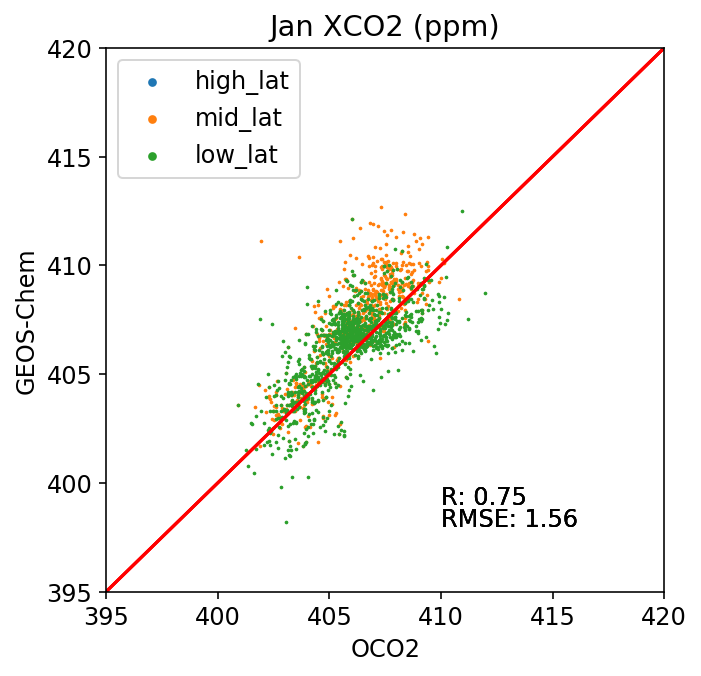

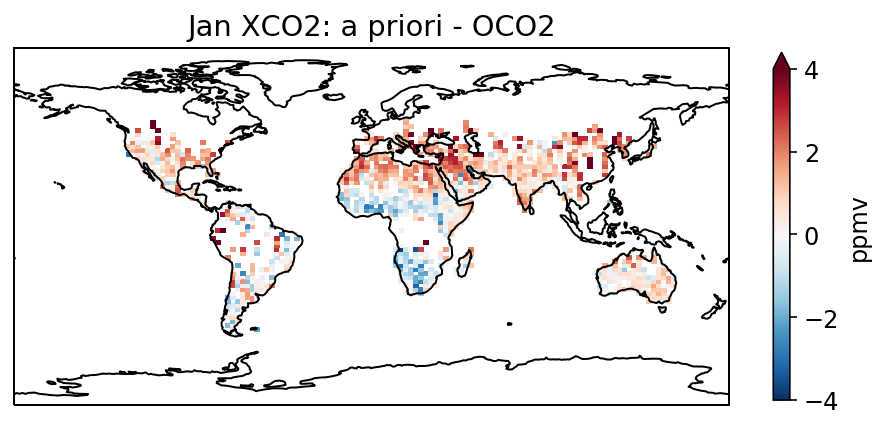

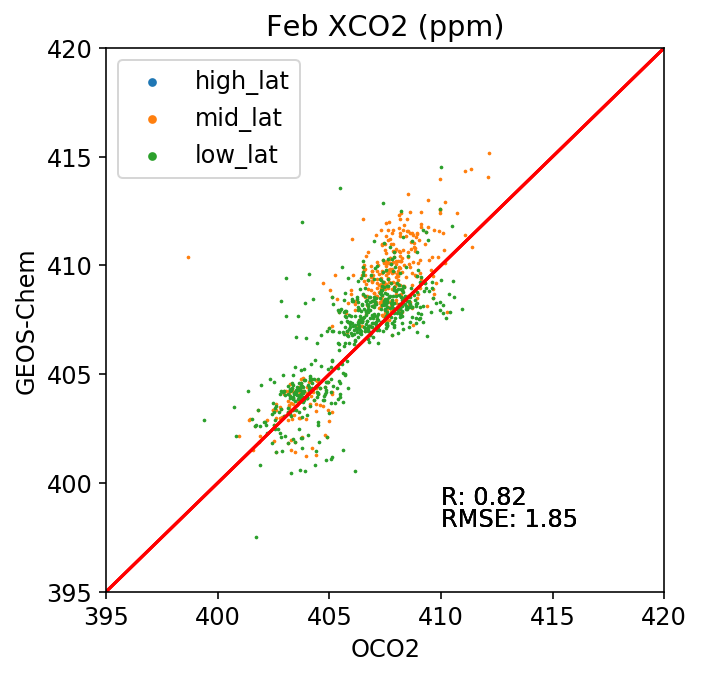

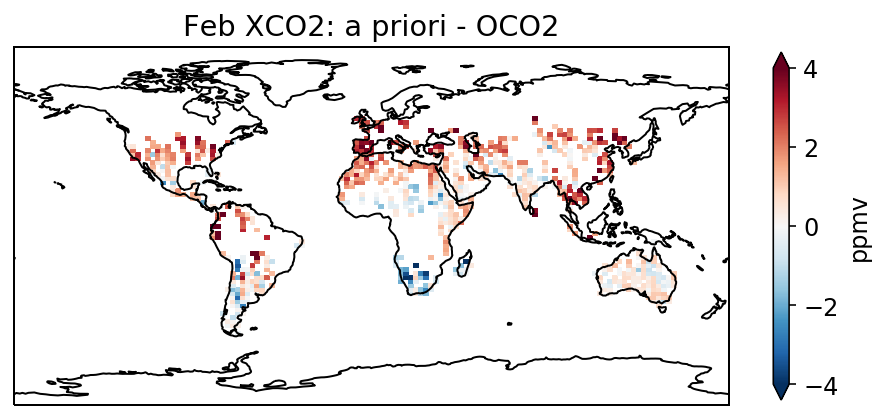

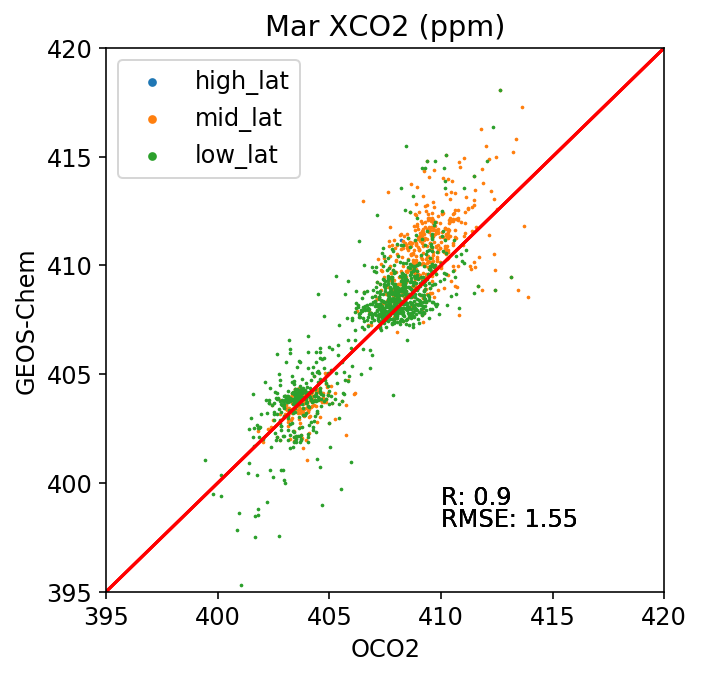

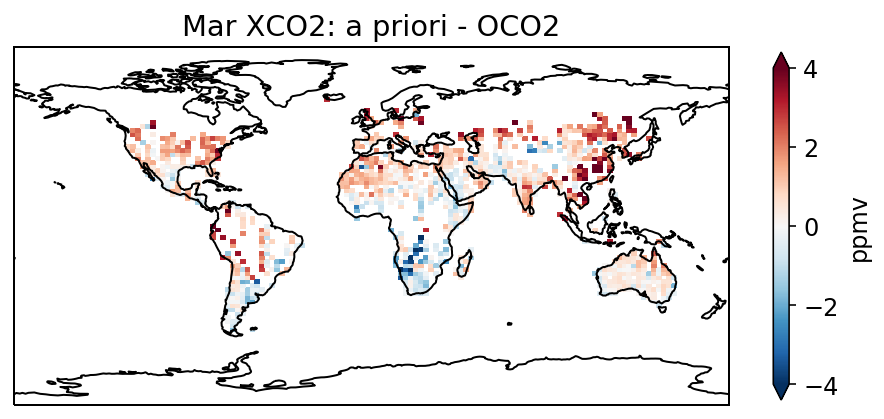

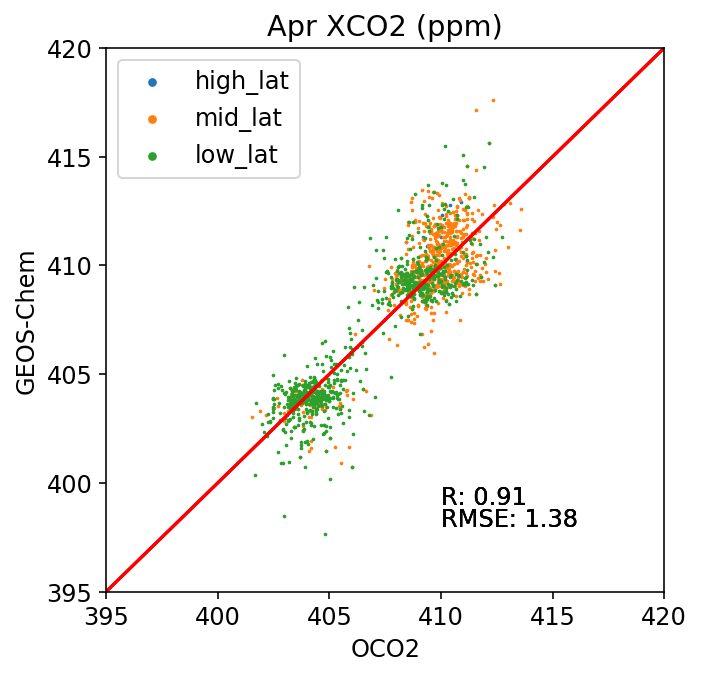

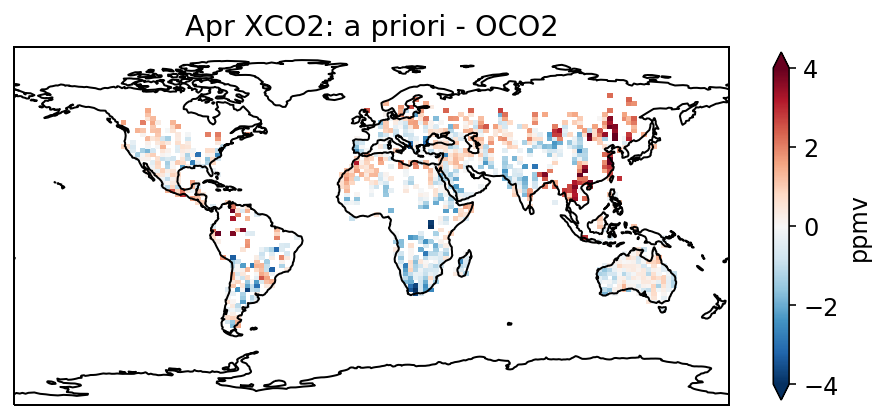

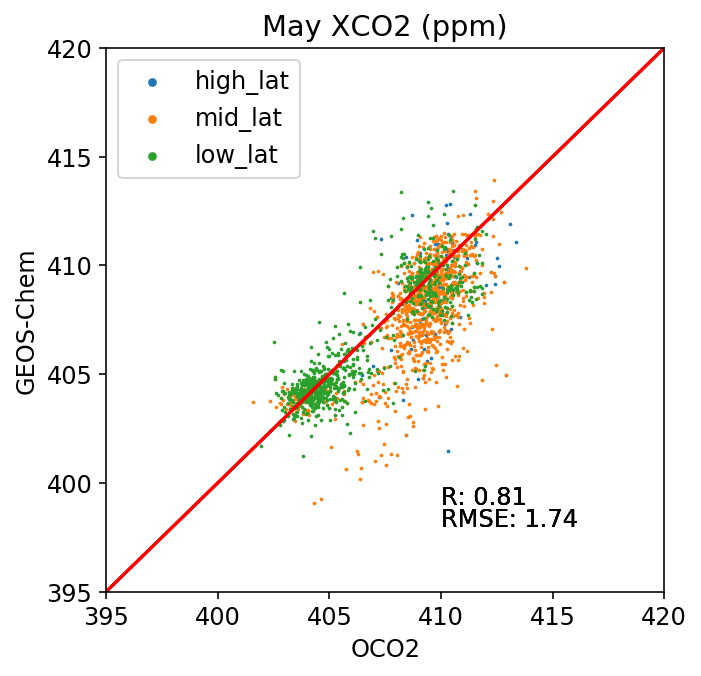

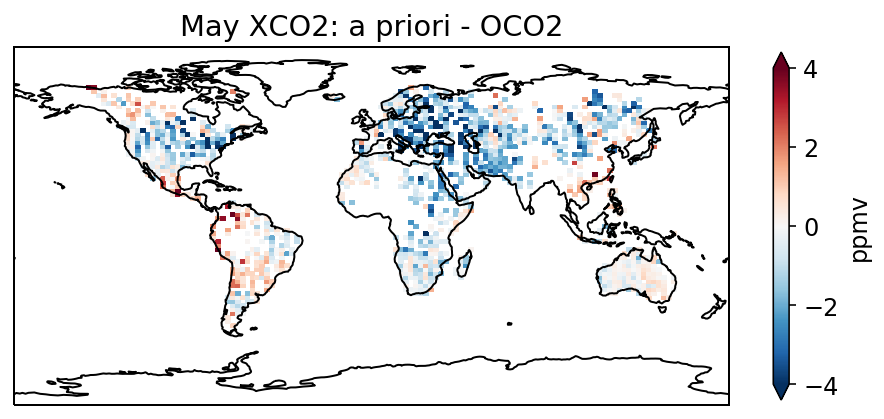

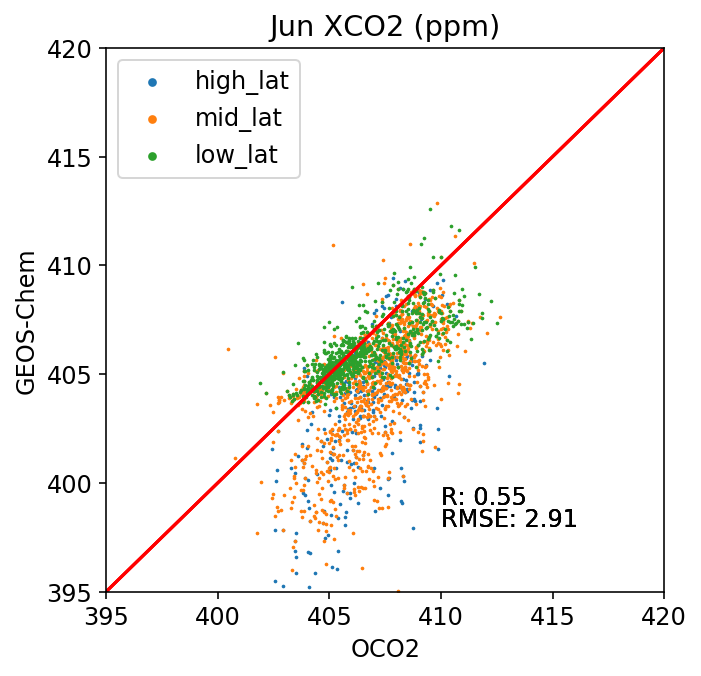

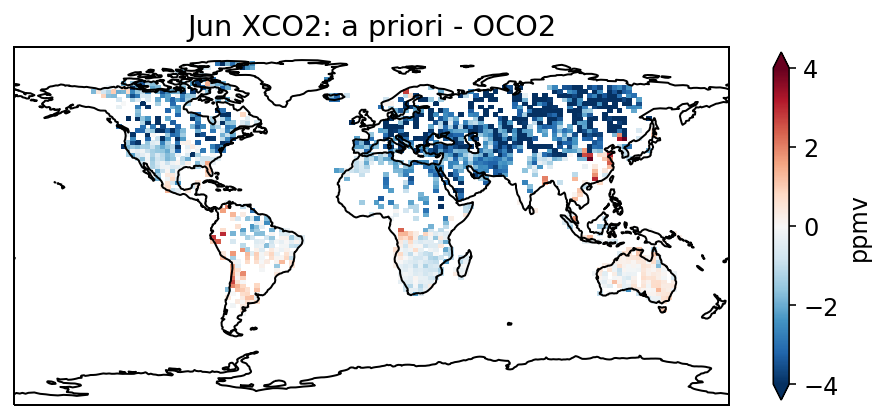

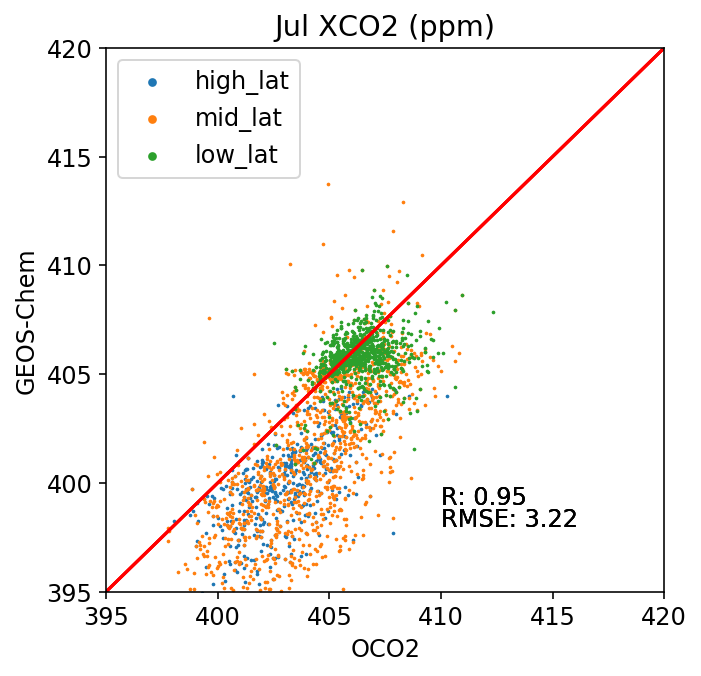

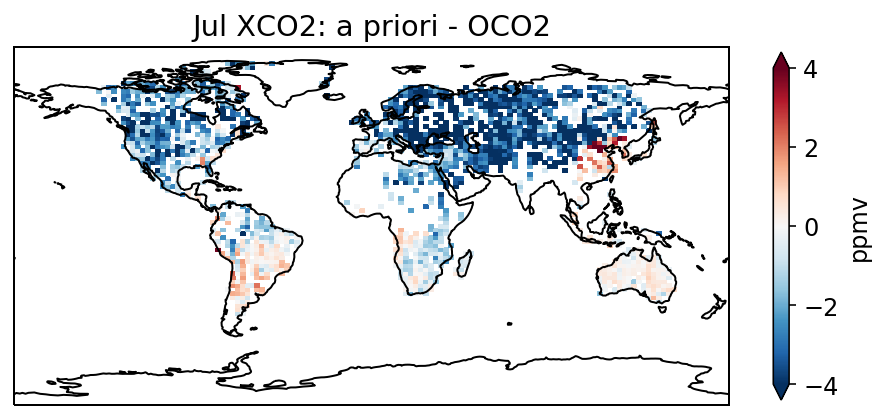

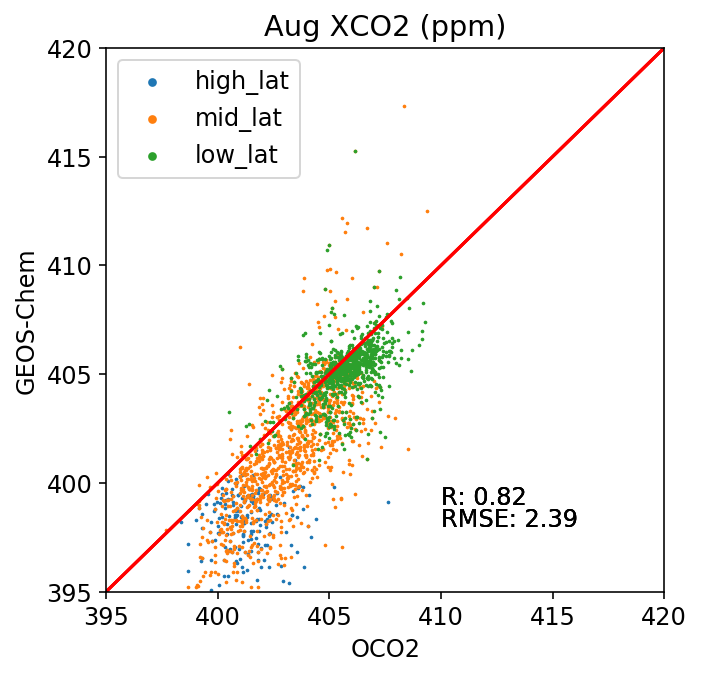

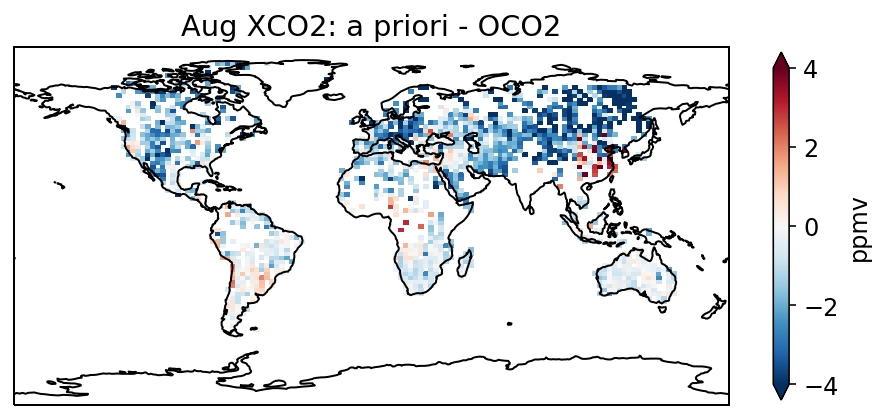

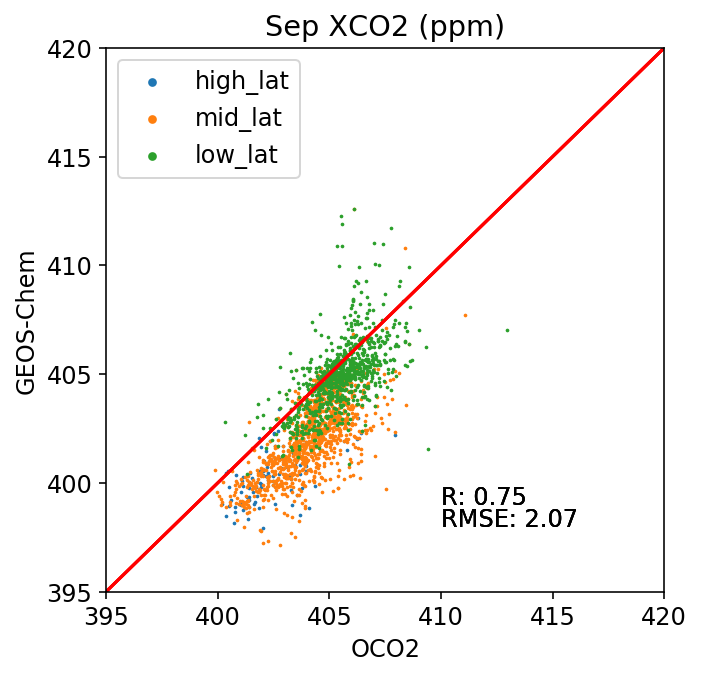

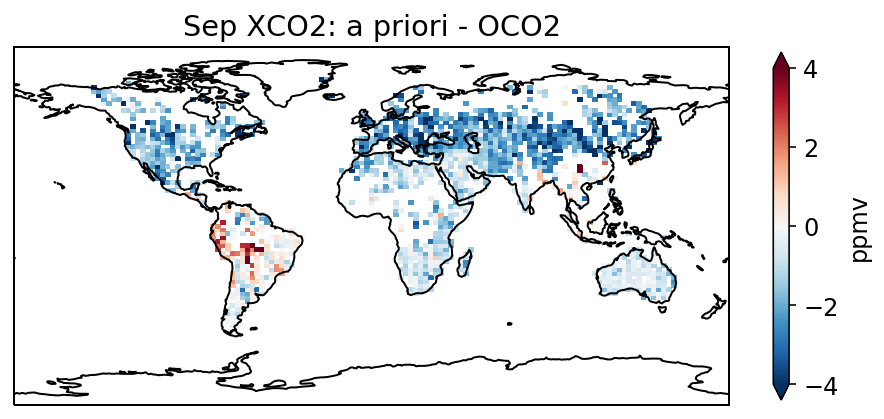

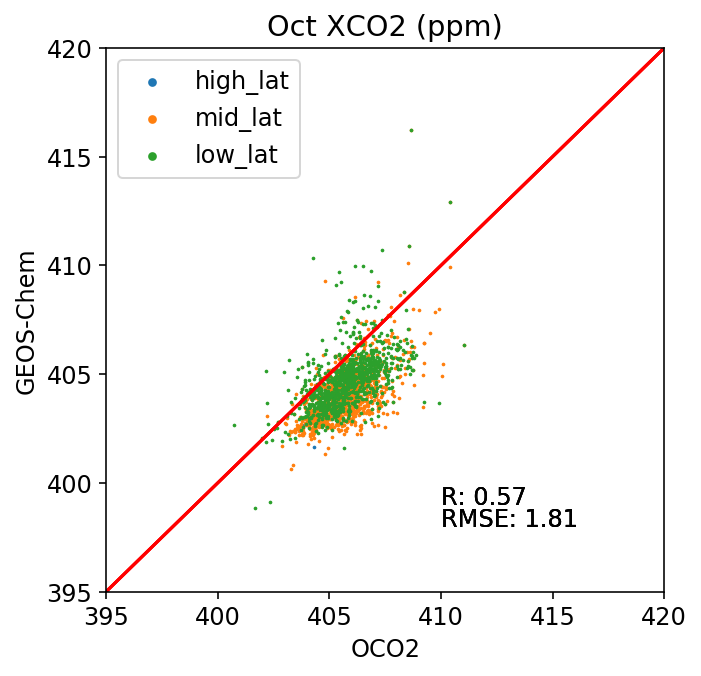

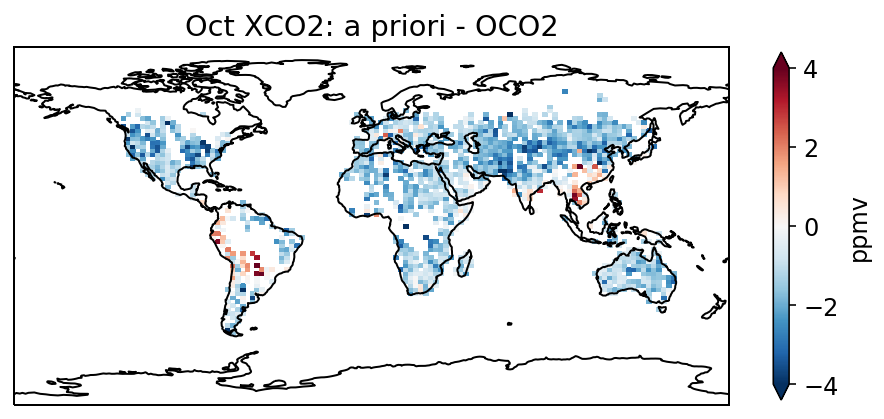

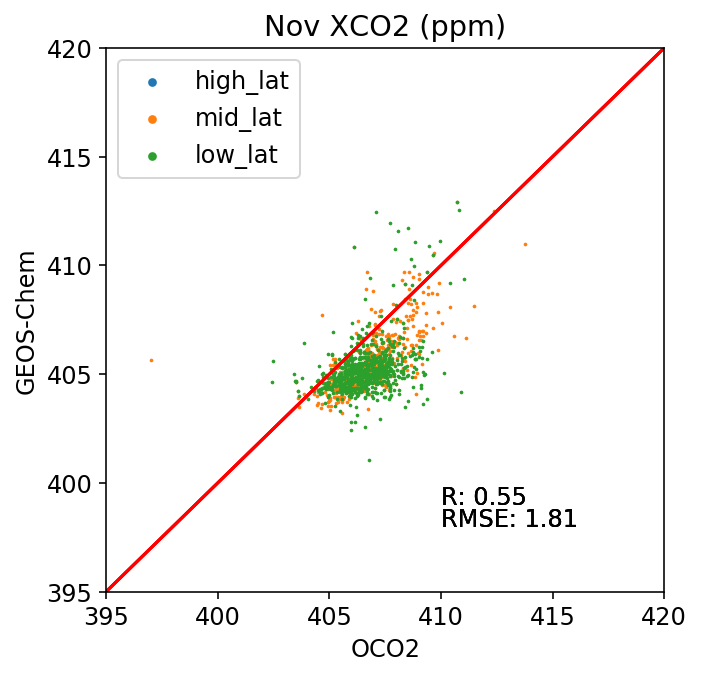

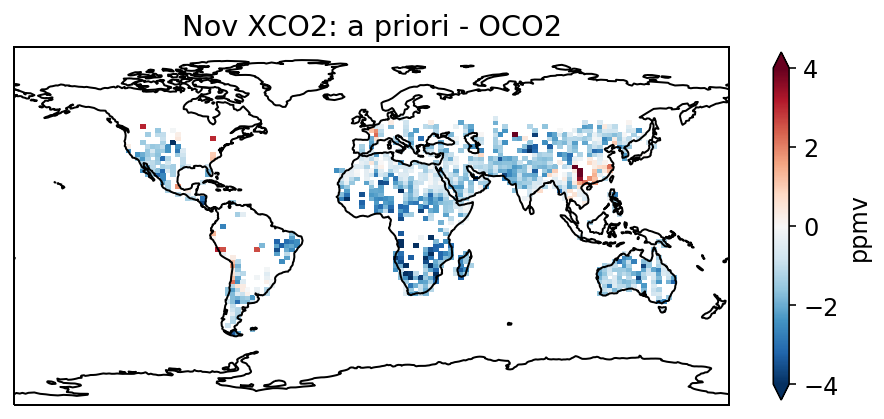

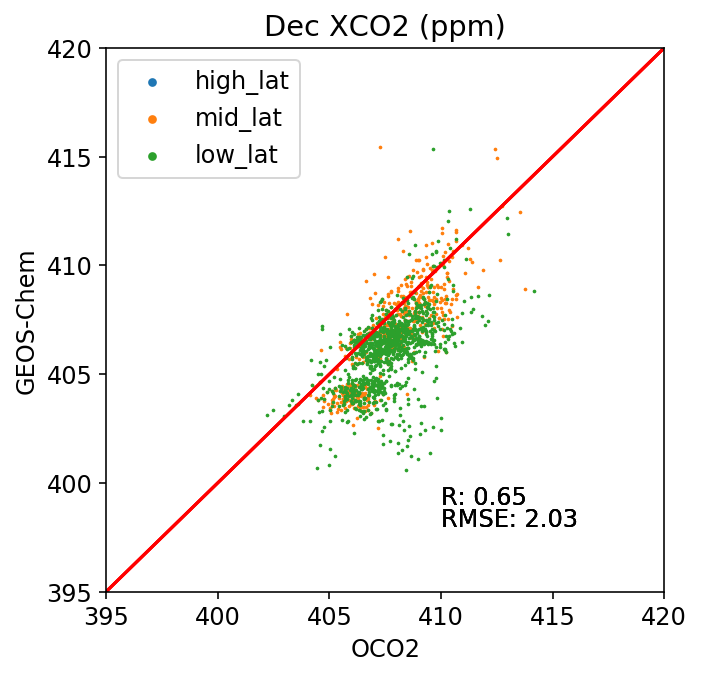

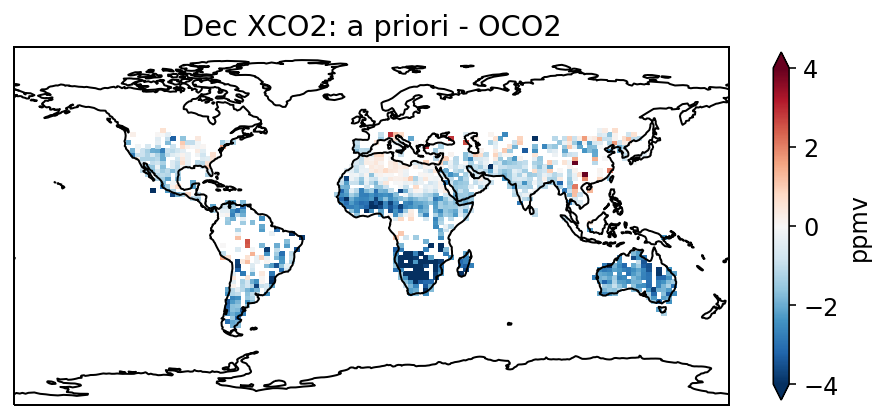

In [14]:
%%time

year = 2018
imonth = 1
mod_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/CO2-2018/nd51/'

for imonth in range(1,13):
    compare_XCO2(mod_dir = mod_dir, 
                 sat_dir = '/geos/u73/msadiq/satellite/oco-2/', 
                 year = year, 
                 month = imonth, 
                 str1_mod = 'interpolated_2d_ts_satellite.', 
                 str1_sat = '2d_OCO2_extract_',
                 needed_vars = ['SpeciesConc_CO2'],
                 mode = 'N')